# ARM Showcase Notebook

ARM shapes are now supported in the OCI Data Science Service. This notebook provides a showcase of what you can do with an ARM-based conda pack. For the most part the underlying platform will not make a difference, but the notebook does a check at the beginning to be sure.

## Upgrade Accelerated Data Science SDK - `oracle-ads`

The Oracle Accelerated Data Science (ADS) SDK is maintained by the Oracle Cloud Infrastructure Data Science service team. It speeds up common data science activities by providing tools that automate and/or simplify common data science tasks, along with providing a data scientist friendly pythonic interface to Oracle Cloud Infrastructure (OCI) services, most notably OCI Data Science, Data Flow, Object Storage, and the Autonomous Database. ADS gives you an interface to manage the lifecycle of machine learning models, from data acquisition to model evaluation, interpretation, and model deployment.

Before you begin with a conda environment, upgrade `oracle-ads` library - [![PyPI](https://img.shields.io/pypi/v/oracle-ads.svg)](https://pypi.org/project/oracle-ads/)  [![Python](https://img.shields.io/pypi/pyversions/oracle-ads.svg?style=plastic)](https://pypi.org/project/oracle-ads/)


You can check your version of `oracle-ads` by running - 

In [1]:
# Show the ADS version and platform

import ads
print(ads.__version__)

import os
print(os.uname().machine)

2.8.10
aarch64


In [2]:
# Uncomment this code and set the correct proxy links if have to setup proxy for internet
# import os
# os.environ['http_proxy']="http://myproxy"
# os.environ['https_proxy']="http://myproxy"

# Use os.environ['no_proxy'] to route trafic directly

In [3]:
# To upgrade ADS uncomment the next line and run the following
#! pip install -q oracle-ads --upgrade

## Authentication
To interact with oci services you need to authenticate with one of the following mechanism - 

### 1. Resource Principal

Resource Principal works by authorizing the notebook instance that you are using to read/manage OCI service resource such as Object Storage, Data Science Jobs, Data Science Models, Data Science Model Deployment, etc. Check these references - 
    
- Refer how to setup policy for managing Data science service resource [here](https://docs.oracle.com/en-us/iaas/data-science/using/policies.htm)
- Refer how to setup policy for managing Object Storage service resource [here](https://docs.oracle.com/en-us/iaas/Content/Identity/policiescommon/commonpolicies.htm#write-objects-to-buckets)
    
    
Other useful resources - 

- https://docs.oracle.com/en-us/iaas/Content/Identity/Concepts/commonpolicies.htm
- https://docs.oracle.com/en-us/iaas/Content/Identity/Concepts/policygetstarted.htm#Getting_Started_with_Policies

Once the policies are setup, configure `oracle-ads` to use resource principal as follows - 


```python
ads.set_auth('resource_principal')
```

### 2. API Key

To setup API Key refer - 

- https://docs.oracle.com/en-us/iaas/Content/API/Concepts/apisigningkey.htm
- https://docs.oracle.com/en-us/iaas/Content/API/Concepts/sdkconfig.htm


Once you have setup the config and the keys, you can setup ads to use API Keys - 

```python

ads.set_auth('api_key')

```

## Working with Data on Object Storage

In [4]:
import ads
import pandas as pd

ads.set_auth("resource_principal")

In [5]:
bucket_name = "hosted-ds-datasets"
namespace = "bigdatadatasciencelarge"


file_name = "titanic/titanic.csv"
df = pd.read_csv(
    f"oci://{bucket_name}@{namespace}/{file_name}",
    storage_options=ads.common.auth.default_signer(),
)

In [6]:
df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


## Prediction (out of sample)

In [7]:
%matplotlib inline

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

### Artificial data

In [9]:
nsample = 50
sig = 0.25
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, np.sin(x1), (x1 - 5) ** 2))
X = sm.add_constant(X)
beta = [5.0, 0.5, 0.5, -0.02]
y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

### Estimation 

In [10]:
olsmod = sm.OLS(y, X)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     765.1
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           3.03e-39
Time:                        17:22:43   Log-Likelihood:                -5.2569
No. Observations:                  50   AIC:                             18.51
Df Residuals:                      46   BIC:                             26.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8821      0.096     51.112      0.0

### In-sample prediction

In [11]:
ypred = olsres.predict(X)
print(ypred)

[ 4.32065924  4.84349851  5.32294472  5.72898794  6.04244867  6.25812896
  6.38566646  6.44795093  6.47736354  6.51045676  6.58194884  6.71901976
  6.93684556  7.23610506  7.60286823  8.01088493  8.42589769  8.81127013
  9.13400622  9.37017143  9.50882509  9.55381794  9.52315943  9.44605887
  9.35812635  9.29552217  9.28901577  9.3589304   9.51180409  9.73931544
 10.01965083 10.3210883  10.60720941 10.8428827  11.00003564 11.0622669
 11.02754104 10.90852293 10.73049692 10.52721273 10.33534045 10.18844575
 10.11147512 10.11665726 10.20149392 10.34917036 10.53131796 10.71267512
 10.85688063 10.93244769]


### Create a new sample of explanatory variables Xnew, predict and plot

In [12]:
x1n = np.linspace(20.5, 25, 10)
Xnew = np.column_stack((x1n, np.sin(x1n), (x1n - 5) ** 2))
Xnew = sm.add_constant(Xnew)
ynewpred = olsres.predict(Xnew)  # predict out of sample
print(ynewpred)

[10.90115969 10.72425126 10.4233168  10.04756722  9.66178141  9.33044607
  9.10196715  8.99681838  9.00252856  9.07673499]


### Plot comparison

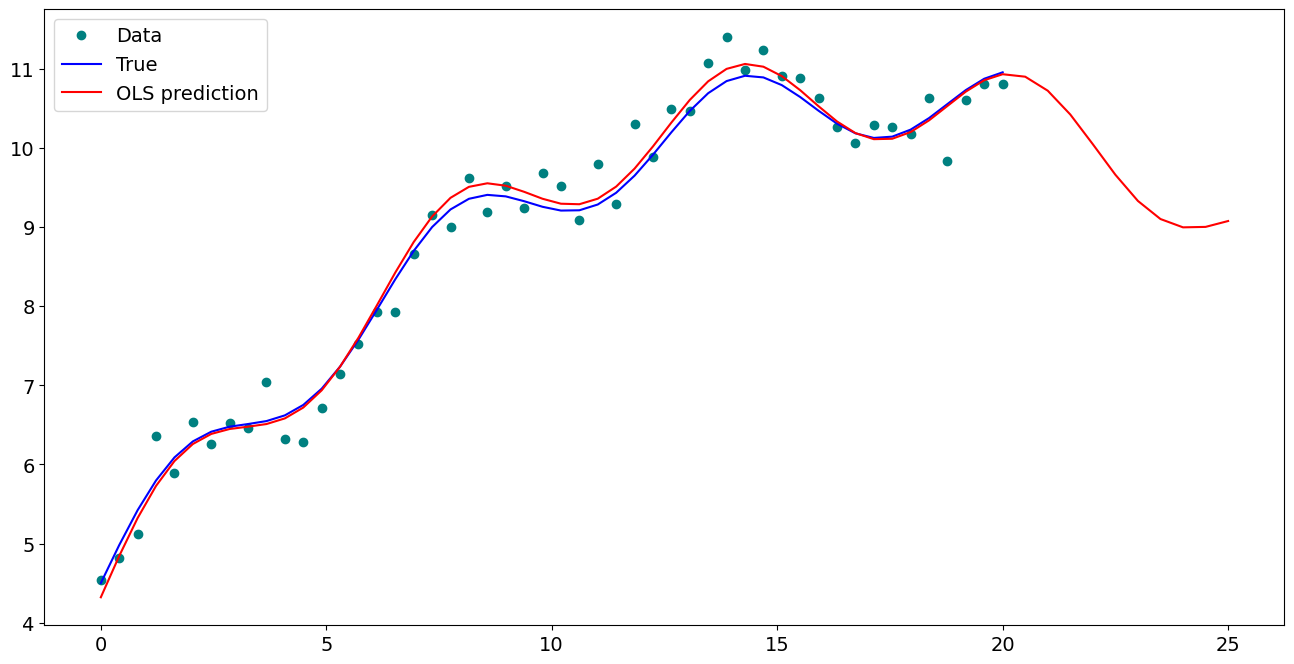

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x1, y, "o", label="Data")
ax.plot(x1, y_true, "b-", label="True")
ax.plot(np.hstack((x1, x1n)), np.hstack((ypred, ynewpred)), "r", label="OLS prediction")
ax.legend(loc="best")

### Predicting with Formulas

Using formulas can make both estimation and prediction a lot easier

In [14]:
from statsmodels.formula.api import ols

data = {"x1": x1, "y": y}

res = ols("y ~ x1 + np.sin(x1) + I((x1-5)**2)", data=data).fit()

We use the `I` to indicate use of the Identity transform. Ie., we do not want any expansion magic from using `**2`

In [15]:
res.params

Intercept           4.882137
x1                  0.530045
np.sin(x1)          0.550650
I((x1 - 5) ** 2)   -0.022459
dtype: float64

Now we only have to pass the single variable and we get the transformed right-hand side variables automatically

In [16]:
res.predict(exog=dict(x1=x1n))

0    10.901160
1    10.724251
2    10.423317
3    10.047567
4     9.661781
5     9.330446
6     9.101967
7     8.996818
8     9.002529
9     9.076735
dtype: float64

## Pandas

Manipulate a pandas dataframe

In [17]:
import pandas as pd

In [18]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

# Define the column names
col_names = ["sepal_length_in_cm", "sepal_width_in_cm","petal_length_in_cm", "petal_width_in_cm", "class"]

# Read data from URL
iris_data = pd.read_csv(url, names=col_names)

iris_data.head() 

,sepal_length_in_cm,sepal_width_in_cm,petal_length_in_cm,petal_width_in_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [19]:
iris_data.loc[4, :].values.flatten().tolist()

[5.0, 3.6, 1.4, 0.2, 'Iris-setosa']

In [20]:
assert iris_data.loc[3, :].values.flatten().tolist() == [4.6, 3.1, 1.5, 0.2, 'Iris-setosa']
assert iris_data.loc[4, :].values.flatten().tolist() == [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']

In [21]:
iris_data.drop(iris_data.index[3], inplace=True)

In [22]:
iris_data.head()

,sepal_length_in_cm,sepal_width_in_cm,petal_length_in_cm,petal_width_in_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa


In [23]:
iris_data.to_csv("altered_data.csv")

In [24]:
new_data = pd.read_csv("altered_data.csv")
new_data.drop(['Unnamed: 0'], axis=1, inplace=True)
new_data.head()


,sepal_length_in_cm,sepal_width_in_cm,petal_length_in_cm,petal_width_in_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [25]:
assert new_data.loc[3, :].values.flatten().tolist() == [5.0, 3.6, 1.4, 0.2, 'Iris-setosa']

### Working with other sources

Learn how to work with other sources [here](https://accelerated-data-science.readthedocs.io/en/latest/user_guide/loading_data/connect.html)

## References

* [Oracle Accelerated Data Science SDK Guide](https://accelerated-data-science.readthedocs.io/en/latest/)
* [Oracle Accelerated Data Science Source Code](https://github.com/oracle/accelerated-data-science)
* [Notebook Examples](https://github.com/oracle-samples/oci-data-science-ai-samples/tree/master/notebook_examples)
* [Cond environments](https://docs.oracle.com/en-us/iaas/data-science/using/conda_understand_environments.htm)
* [Publish Conda Environments](https://docs.oracle.com/en-us/iaas/data-science/using/conda_publishs_object.htm)